<a href="https://colab.research.google.com/github/Aniket7773/Signature-Verification-Model/blob/main/Siamese_retrain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


528/528 [==============================] - 10332s 20s/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 6.3470e-06 - val_accuracy: 1.0000


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


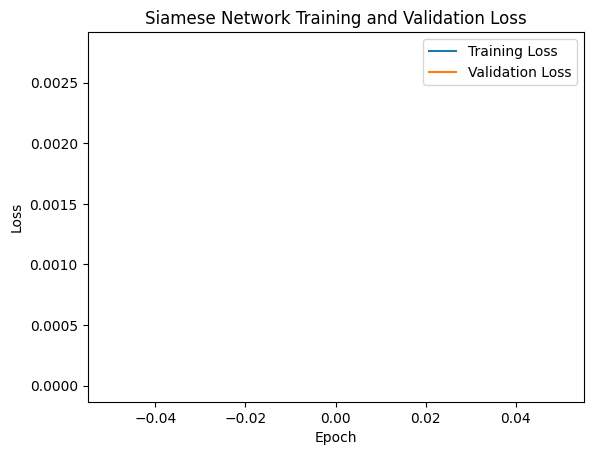

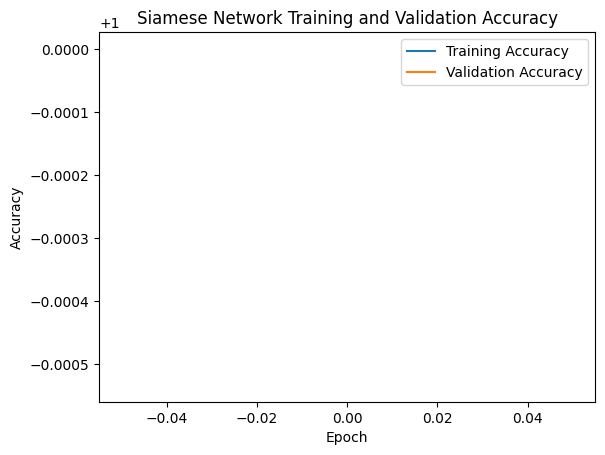

In [ ]:
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

# Define the root directory path
root_dir = "/content/drive/MyDrive/Colab Notebooks/sign_data/train"

# Initialize empty lists to store file paths and labels
file_paths = []
labels = []

# Function to label images and append to lists
def label_images(directory, label):
    for filename in os.listdir(directory):
        if filename.endswith((".png", ".PNG")):  # Assuming your images are in PNG format
            image_path = os.path.join(directory, filename)
            file_paths.append(image_path)
            labels.append(label)

# Traverse the directory structure and label images
for subdir in os.listdir(root_dir):
    subdir_path = os.path.join(root_dir, subdir)

    if os.path.isdir(subdir_path):
        if subdir.endswith("_forg"):
            label = 0  # Forgery label
        else:
            label = 1  # Genuine label

        image_dir = os.path.join(subdir_path)
        if os.path.exists(image_dir):
            label_images(image_dir, label)

# Split the data into genuine and forged signatures
genuine_signatures = [file_paths[i] for i in range(len(file_paths)) if labels[i] == 1]
forged_signatures = [file_paths[i] for i in range(len(file_paths)) if labels[i] == 0]

# Create pairs of genuine and forged signatures
image_pairs = []
pair_labels = []

for genuine_path in genuine_signatures:
    for forged_path in forged_signatures:
        image_pairs.append((genuine_path, forged_path))
        # Label as similar (1) if both images are genuine or both are forged, dissimilar (0) otherwise
        pair_labels.append(int(genuine_path.split("/")[-2] == forged_path.split("/")[-2]))

# Shuffle and split the data into training and validation sets
image_pairs = np.array(image_pairs)
pair_labels = np.array(pair_labels)

X_train, X_val, y_train, y_val = train_test_split(image_pairs, pair_labels, test_size=0.2, random_state=42)

# Define a function to load and preprocess images
def load_and_preprocess_image(file_path):
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # Convert to grayscale
    img = cv2.resize(img, (224, 224))  # Resize to your desired input size
    img = np.expand_dims(img, axis=-1)  # Add a single channel dimension
    img = img / 255.0  # Normalize pixel values to [0, 1]
    return img

# Create a Siamese Network architecture
input_shape = (224, 224, 1)  # Adjust input shape based on your image size

base_model = keras.Sequential([
    keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
    keras.layers.MaxPooling2D((2, 2)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
])

input_a = keras.layers.Input(shape=input_shape)
input_b = keras.layers.Input(shape=input_shape)

processed_a = base_model(input_a)
processed_b = base_model(input_b)

# Calculate L1 distance between the processed embeddings
distance = keras.layers.Lambda(lambda x: keras.backend.abs(x[0] - x[1]))([processed_a, processed_b])

# Output prediction (1 for similar, 0 for dissimilar)
output = keras.layers.Dense(1, activation='sigmoid')(distance)

# Create the Siamese model
siamese_model = keras.models.Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Define a data generator function for loading and preprocessing image pairs
def data_generator(image_pairs, pair_labels, batch_size):
    while True:
        indices = np.random.choice(len(image_pairs), batch_size)
        X_batch = [np.zeros((batch_size,) + input_shape) for _ in range(2)]
        y_batch = np.zeros((batch_size,))

        for i, idx in enumerate(indices):
            X_batch[0][i] = load_and_preprocess_image(image_pairs[idx][0])
            X_batch[1][i] = load_and_preprocess_image(image_pairs[idx][1])
            y_batch[i] = pair_labels[idx]

        yield X_batch, y_batch

# Train the Siamese model
batch_size = 32  # Adjust batch size as needed
steps_per_epoch1 = len(X_train) // batch_size
steps_per_epoch2 = (steps_per_epoch1) // batch_size
validation_steps = len(X_val) // batch_size

history= siamese_model.fit(
    data_generator(X_train, y_train, batch_size),
    epochs=1,  # Adjust the number of epochs
    steps_per_epoch=steps_per_epoch2,
    validation_data=data_generator(X_val, y_val, batch_size),
    validation_steps=validation_steps,
)

siamese_model.save('siamese-sign-verify2.h5')
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Siamese Network Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Siamese Network Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
history.history

{'loss': [0.0027772150933742523],
 'accuracy': [0.9994673132896423],
 'val_loss': [6.347017006191891e-06],
 'val_accuracy': [1.0]}

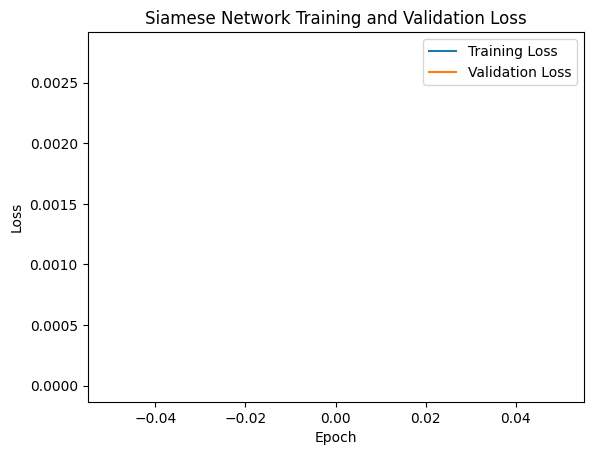

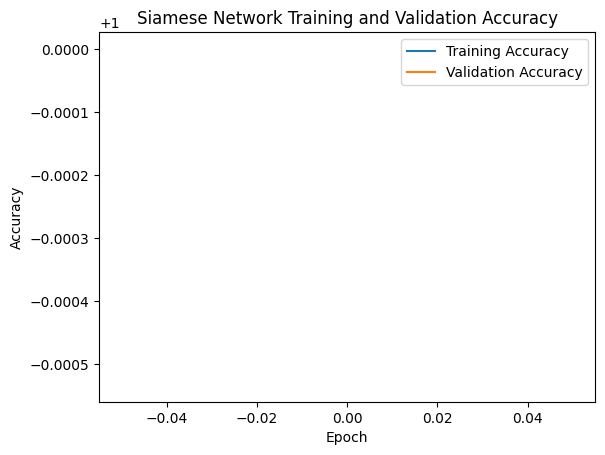

In [ ]:
# Plot training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Siamese Network Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Siamese Network Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()